In [1]:
import numpy as np
import pandas as pd
import h5py
import python_utils_jjm as utils_jjm
from tqdm import tqdm
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/Users/johnmarshall/caiman_data/post_cnmfe_analysis')
import miniscope_analysis as ma 

In [3]:
reload(utils_jjm)

<module 'python_utils_jjm' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/python_utils_jjm.py'>

In [38]:
## path to CNMFE data
dir_path_cnmfe = '/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/'

In [39]:
session = 'GRIN011_fullsession_Z_scored.h5'
from_file = h5py.File(dir_path_cnmfe+session, 'r')

In [40]:
list(from_file.keys())

['C_Z_scored']

In [41]:
z_scored_df = pd.DataFrame(np.transpose(from_file['C_Z_scored'][:]))

In [42]:
## path to location tracking data 

dir_path = '/Volumes/My_Passport/MiniscopeMovies/GRIN011_H10_M19_S59/'
tracking_file = 'session_tracking_data.csv'
frame_clock_info = 'timestamp.dat'
tracking_from_file = pd.read_csv(dir_path+tracking_file)
frame_clock_df = pd.read_table(dir_path+frame_clock_info)

/Users/johnmarshall/miniconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  import sys


In [43]:
frame_clock_df.head()

,camNum,frameNum,sysClock,buffer
0,0,1,506567780,1
1,1,1,506567806,1
2,1,2,15,1
3,0,2,7,1
4,1,3,47,1


In [44]:
cnmfe_range = (0, np.shape(from_file['C_Z_scored'][:])[1])

In [45]:
cnmfe_range

(0, 25000)

In [46]:
# load time stamps 
msCam_timestamps = frame_clock_df[frame_clock_df['camNum'] == 0].set_index('frameNum')[cnmfe_range[0]:cnmfe_range[1]]
behavCam_timestamps = frame_clock_df[frame_clock_df['camNum'] == 1].set_index('frameNum')
# reset initial clock value to 0 
msCam_timestamps['sysClock'][1] = 0
behavCam_timestamps['sysClock'][1] = 0

In [47]:
msCam_timestamps = utils_jjm.align_behavior_data(msCam_timestamps, behavCam_timestamps)

 29%|██▉       | 7214/25000 [01:06<03:00, 98.54it/s] 

KeyboardInterrupt: 

In [13]:
msCam_timestamps.reset_index(inplace=True)
msCam_timestamps.head()

,frameNum,camNum,sysClock,buffer,behavCam_frames,sys_clock_behavCam
0,1,0,0,1,1,0
1,2,0,7,1,1,0
2,3,0,58,1,3,47
3,4,0,108,1,5,111
4,5,0,158,1,6,143


In [14]:
#generate velocity Z-score
v_zscore = stats.zscore(tracking_from_file['velocity'])

In [15]:
behavior_aligned = pd.concat([msCam_timestamps, tracking_from_file[:len(msCam_timestamps)], pd.DataFrame({'velocity_z_score' : v_zscore})[:len(msCam_timestamps)]], axis =1 )

In [16]:
analysis_df = pd.concat([behavior_aligned, z_scored_df], keys=['behavior', 'C_z_scored'], axis=1)

In [17]:
analysis_df.to_hdf(dir_path + 'aligned_to_behavior.h5', key = 'df')

/Users/johnmarshall/miniconda2/envs/caiman/lib/python3.6/site-packages/pandas/io/pytables.py:268: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0_level1] [items->None]

  f = lambda store: store.put(key, value, **kwargs)
/Users/johnmarshall/miniconda2/envs/caiman/lib/python3.6/site-packages/pandas/io/pytables.py:268: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items_level1] [items->None]

  f = lambda store: store.put(key, value, **kwargs)
/Users/johnmarshall/miniconda2/envs/caiman/lib/python3.6/site-packages/pandas/io/pytables.py:268: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_items_level1] [items->None]

  f = lambda store: s

In [34]:
#pixel dims are 752x480
#get and save cell centers of mass
cnmfe_results = '/Volumes/My_Passport/cnmfe_analysis_files/GRIN027/memmap_0000memmap_0004_resized_source_extraction_13:35:14.243/frames_1_5000/LOGS_11-Oct_13_40_54/11-Oct_13_51_17.mat_out.mat'
mat_results = ma.miniscope_session(cnmfe_results)

In [35]:
#get and save cell centers of mass

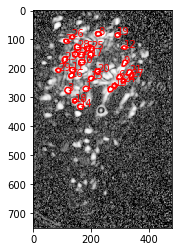

In [36]:
coordinates = utils_jjm.plot_contours(mat_results.cnmfe_results['A'].todense(), 
                        mat_results.cnmfe_results['Cn'], 
                        list_to_plot=range(np.shape(mat_results.cnmfe_results['C'])[0]), 
                        display_numbers=True, maxthr=.6,cmap='gray', colors='r')
coms = pd.DataFrame(np.array([coordinates[x]['CoM'] for x in range(np.shape(coordinates)[0])]), columns = ['x', 'y'],
                   index = range(np.shape(coordinates)[0]))


In [37]:
#save COM to hdf5 
coms.to_hdf('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/' + 'GRIN027_coms.h5', key = 'df')

In [48]:
analysis_df = pd.read_hdf('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/GRIN011_aligned_to_behavior.h5')
coms_df = pd.read_hdf('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/GRIN011_coms.h5')

In [50]:
analysis_df['C_z_scored']

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,-0.228888,-0.347683,-0.084443,0.315216,0.736817,0.050184,-0.410957,0.097476,3.419068,0.139459,...,-0.910805,-0.716258,-1.003124,-1.671407,-0.038928,-0.093372,-0.388336,-0.576353,-0.959844,-0.809900
1,-0.244563,-0.347918,-0.103346,0.271259,0.678833,0.020152,-0.416319,0.068316,3.185303,0.110913,...,-0.910805,-0.716258,-1.015537,-1.671407,0.591083,0.196577,-0.418647,-0.601489,-0.959844,-0.832530
2,-0.259137,-0.348129,-0.121097,0.229800,0.623781,-0.007913,-0.421413,0.040584,2.965232,0.083968,...,-0.910805,-0.716258,-1.026868,-1.671407,0.477424,0.081509,-0.447924,-0.625486,-0.959844,-0.853981
3,-0.272688,-0.348320,-0.137766,0.190696,0.571513,-0.034137,-0.426252,0.014210,2.758052,0.058535,...,-0.910805,-0.716258,-1.037211,-1.671407,0.373363,0.428509,-0.476204,-0.648395,-0.959844,-0.874314
4,-0.177926,-0.348492,-0.153420,0.153814,0.521888,-0.058643,-0.430848,-0.010873,2.563009,0.034529,...,-0.910805,-0.716258,-1.046652,-1.671407,0.278089,0.285534,-0.503520,-0.670265,-0.959844,-0.893588
5,-0.197180,-0.348647,-0.168120,0.119027,0.474772,-0.081543,-0.435214,-0.034728,2.379391,0.011870,...,-0.910805,-0.716258,0.376351,-1.671407,0.190861,0.159762,-0.529905,-0.691145,-0.959844,-0.911858
6,-0.215081,-0.348787,-0.181923,0.086216,0.430039,-0.102942,-0.439362,-0.057414,2.206529,0.214284,...,-0.910805,-0.716258,1.028622,-1.671407,0.110999,1.107654,-0.555392,-0.711078,-0.959844,0.740367
7,-0.014642,-0.348913,-0.194886,0.055270,0.387567,0.480867,-0.443302,-0.078990,2.043793,0.631699,...,-0.910805,-0.716258,0.839055,-1.671407,0.037881,0.882961,-0.580009,-0.730108,-0.959844,0.636963
8,-0.045361,-0.349027,-0.207058,0.026082,0.347243,0.422606,-0.447045,-0.099510,1.890590,0.575534,...,-0.910805,-0.716258,0.666017,-1.671407,-0.029063,0.685304,-0.603788,-0.748275,-0.959844,0.538947
9,-0.073922,-0.349130,-0.218489,-0.001448,0.308958,0.368164,-0.450600,-0.119024,1.746361,0.522519,...,-0.910805,-0.716258,0.508066,-1.671407,-0.090353,0.511430,-0.626757,-0.765619,-0.959844,0.446037


In [19]:
#disp_range = (0,len(analysis_df['behavior']['sysClock']))
disp_range = (0,20000)

In [20]:
analysis_df['behavior']['sys_clock_behavCam'][8000]

400223

In [21]:
analysis_df['behavior']['File'][4000]

'behavCam05.avi'

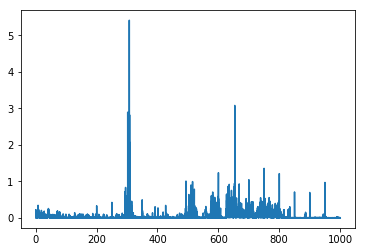

In [22]:
plt.plot((analysis_df['behavior']['sysClock']/1000)[disp_range[0]:disp_range[1]], analysis_df['behavior']['velocity'][disp_range[0]:disp_range[1]])
plt.show()

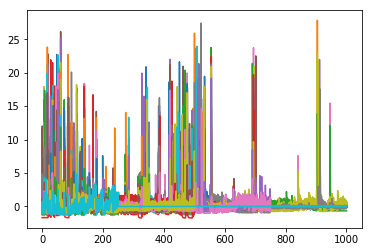

In [23]:
plt.plot((analysis_df['behavior']['sysClock']/1000)[disp_range[0]:disp_range[1]], analysis_df['C_z_scored'][disp_range[0]:disp_range[1]])
plt.show()

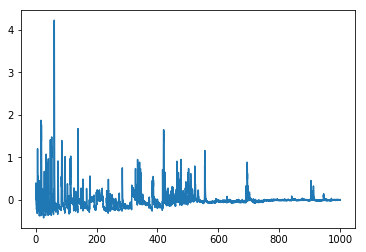

In [24]:
plt.plot((analysis_df['behavior']['sysClock']/1000)[disp_range[0]:disp_range[1]], analysis_df['C_z_scored'].mean(axis=1)[disp_range[0]:disp_range[1]])
plt.show()

In [ ]:
test = np.zeros(10)

In [ ]:
test[5:10] = np.ones(5)

In [ ]:
test